In [34]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

# HDBSCAN clustering algorithm
import hdbscan

GitHub Link: https://github.com/alonakos/Final_Project_Section03_Team8/tree/main

**Data Import**

The data was queried using the custom-written (by me) module: https://github.com/alonakos/stellar_kinematics/blob/main/modules.py

I retrieved Gaia DR3 positions, proper motions, and radial velocities using my query script, then converted all data into Galactocentric coordinates. Using AGAMA and 1,000 Monte-Carlo draws per star, I tracked each orbit and grabbed average velocities, actions, and orbital stats like pericentre, apocentre, and eccentricity. The result is a filtered_stars CSV.

In [35]:
star_data = pd.read_csv("filtered_stars.csv")

**Data Cleaning**

The Gaia Data Release 3 provides astrometric and photometric data on stars. Given the limited compute, I queried 552 stars with 22 variables (astrometric mostly), including celestial coordinates (right ascension and declination), proper motion, parallax, radial velocity, and photometric data. For data cleaning I need to drop stars without radial velocity, and containing NaN values.

In [36]:
star_data_clean = star_data.dropna(how='all')
# star_data_clean = star_data.fillna(0)
type(star_data_clean)

pandas.core.frame.DataFrame

In [7]:
star_data_clean['U']

,U
0,-14.527353
1,7.911635
2,-35.152848
3,44.409299
4,21.559445
...,...
586,-43.639656
587,-154.924803
588,-177.727346
589,-125.610253


In [26]:
# Print the columns of the cleaned DataFrame
print("Columns in star_data_clean:", star_data_clean.columns)

Columns in star_data_clean: Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'pmra_pmdec_corr', 'parallax', 'parallax_error',
       'phot_g_mean_mag', 'bp_rp', 'dr2_radial_velocity',
       'dr2_radial_velocity_error', 'U', 'V', 'W', 'T', 'Prograde', 'V-500',
       'cluster'],
      dtype='object')


**Exploratory Data Analysis**

The most significant variables, such as U, V, and W velocities, U, V velocities are in the plane of the galactic disk, and W is perpendicular to the galactic disk. Histograms of the velocity distribution in three direction shows that data contains physically plausible velocity ranges.

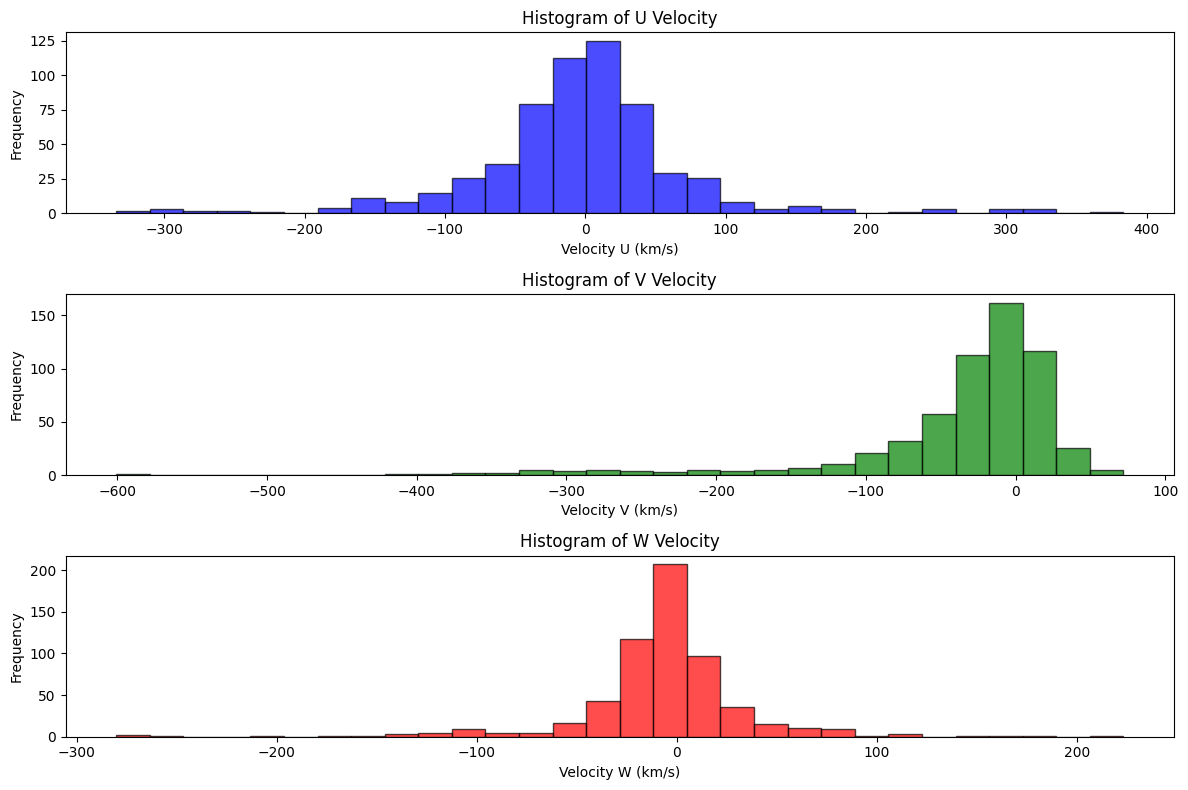

In [ ]:
U = star_data_clean['U']
V = star_data_clean['V']
W = star_data_clean['W']

# Set up the figure and subplots
plt.figure(figsize=(12, 8))

# Plot histogram for U velocity
plt.subplot(3, 1, 1)
plt.hist(U, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of U Velocity')
plt.xlabel('Velocity U (km/s)')
plt.ylabel('Frequency')

# Plot histogram for V velocity
plt.subplot(3, 1, 2)
plt.hist(V, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of V Velocity')
plt.xlabel('Velocity V (km/s)')
plt.ylabel('Frequency')

# Plot histogram for W velocity
plt.subplot(3, 1, 3)
plt.hist(W, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Histogram of W Velocity')
plt.xlabel('Velocity W (km/s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**K-Means Experiments**

K-means approach did not produce stable, meaningful clusters, so I used HDBSCAN for it's ability to handle noisy, multidimentional data.

In [ ]:
# Define the first feature set with angular momentum components and the mean orbital energy for clustering
feature_set1 = ["j_phi(kpc s^(-1))", "j_r(kpc km s^-1)", "j_z(kpc km s^(-1))", "energy_mean(km^2 s^(-2))"]

# Define the second feature set with the standard deviations of the angular momentum components and orbital energy
feature_set2 = ["j_phi_std(kpc km s^(-1))", "j_r_std(kpc km s^-1)", "j_z_std(kpc km s^-1)", "energy_std(km^2 s^(-2))"]

# Define the third feature set, expanding feature_set2 by adding the standard deviations of velocity components
feature_set3 = ["j_phi_std(kpc km s^(-1))", "j_r_std(kpc km s^-1)", "j_z_std(kpc km s^(-1))",
                "energy_std(km^2 s^(-2))", "v_z_std(km/s)", "v_r_std(km/s)", "v_phi_std(km/s)"]

# Apply KMeans clustering with 3 clusters on the cleaned star data
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(star_data_clean)

# Feature Set 1:
# j_phi (kpc s^(-1)) → "Rotation around the Galaxy"
# j_r (kpc km s^-1) → "Movement towards/away from Galaxy Center"
# j_z (kpc km s^(-1)) → "Up/Down Movement in Galaxy"
# energy_mean (km^2 s^(-2)) → "Average Energy of Stars"

# Feature Set 2:
# j_phi_std (kpc km s^(-1)) → "Variation in Rotation"
# j_r_std (kpc km s^-1) → "Variation in Radial Movement"
# j_z_std (kpc km s^(-1)) → "Variation in Up/Down Movement"
# energy_std (km^2 s^(-2)) → "Variation in Energy"


# Retrieve the cluster centers from the KMeans algorithm
# kmeans.cluster_centers_

**MODELING: HDBSCAN**

The most involved part is to determine the best combination of min_cluster_size and min_samples. After the trial runs, I have settled on min_cluster_size=3, min_samples=5, but additional optimization in the future might be needed.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


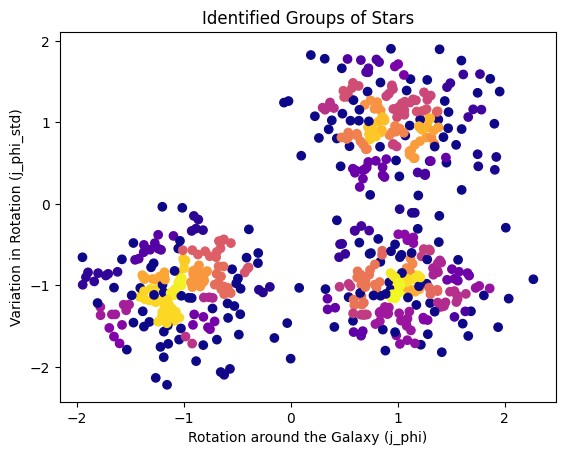

In [32]:
features = ["U", "V", "W"]
X = star_data_clean[features].values

X_scaled = StandardScaler().fit_transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=5)
labels = clusterer.fit_predict(X_scaled)
star_data_clean["cluster"] = labels

# Plot the clustered data
plt.scatter(star_data[:, 0], star_data[:, 1], c=labels, cmap='plasma')
plt.title('Identified Groups of Stars')

plt.xlabel('Rotation around the Galaxy (j_phi)')
plt.ylabel('Variation in Rotation (j_phi_std)')
plt.show()

In [ ]:
# Get the number of unique clusters (excluding noise points labeled as -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters found: {n_clusters}")

Number of clusters found: 12


**Evaluation**

Number of clusters found: 12

These groups are prime candidates for new disrupted satellign galaxies, helping resolve the Missing Satellite Galaxies Problem. If I had more compute, I would push beyond three-velocity clustering, using chemo-kinematic clustering.

**Deployment**

 If automated, the pipeline could run on each new Gaia release to update the catalogue. A lightweight web dashboard could also help researchers upload custom star samples, set various hyperparameters, and receive real-time cluster labels.

**Discussion and Conclusion**

This project identified clusters of stars that may provide insights into the Milky Way's and the Universe's history. Groups with consistent kinematic properties are prime candidates for further study. Spectroscopic analysis of these stars' chemical compositions could reveal whether they share the same origin and if they represent distinct systems that merged with the Milky Way over time.
